In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
torch.manual_seed(4701)
np.random.seed(4701)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model_ft = torch.load('model-final')
else:
    model_ft = torch.load('model-final', map_location=torch.device('cpu'))
model_ft.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
#constants

data_dir = '../../dataset/'
batch_size = 8

In [3]:
def calc_mean_std(dataloader):
    """
    Returns a list of the average RGB values and a list of the standard of
    the RGB values.

    Extracts the mean and standard of RGB values of every image in dataloader
    and then returns the average.

    Parameter dataloader: images to find the mean and standard of
    Precondition: dataloader is a Torch dataloader object

    CITATION: This function was taken and adapted from the following source:
        https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7
    """
    mean = []
    std = []

    # Find and append the mean and standard of each image in dataloader
    for data in dataloader:
        img, _ = data

        batch_mean = torch.mean(img, (0,2,3))
        batch_std = torch.std(img, (0,2,3))

        mean.append(batch_mean)
        std.append(batch_std)

    # Find and return the mean and standard of every image in dataloader
    mean = np.mean([m.numpy() for m in mean], axis=0)
    std = np.mean([s.numpy() for s in std], axis=0)

    return mean, std

In [4]:
def preprocess_data():
    """
    Returns the transformation necessary to normalize the image data.

    Creates a normalization transformation that results in the training data
    having a mean of 0 and a standard deviation of 1.
    """
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200)
    ])

    # Creates a dataloader object for the training and validation sets
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), \
        transform)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, \
        batch_size=batch_size, shuffle=True, num_workers=4)

    mean, std = calc_mean_std(train_dataloader)

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200),
        transforms.Normalize(mean,std)
    ])

In [5]:
transformations = preprocess_data()
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x if x == 'train' else 'validation'), transformations) for x in ['train', 'val', 'test']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}

In [6]:
# Creates a dataloader object for the training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms.Compose([transforms.ToTensor()]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, \
    batch_size=batch_size, shuffle=True, num_workers=0)

mean, std = calc_mean_std(train_dataloader)
classes = image_datasets['train'].classes

In [7]:
def softmax(x):
    # https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [12]:
def k_mismatches(model, dataloader, k):
    mismatches = []
    count = 0
    for data, label in dataloader:
        data = data.to(device)
        output = model(data)
        _, prediction = torch.max(output, 1)
        for i, (p, l) in enumerate(zip(prediction, label)):
            count += 1
            mismatches.append((p.item(), l.item(), data[i].cpu().numpy(), softmax(output[i].cpu().detach().numpy())))
            if count == k:
                return mismatches  
    return mismatches

In [13]:
def unnormalize(img, mean, std):
    # img_unnormalized = std * (img + mean)
    img = copy.deepcopy(img)
    for i in range(img.shape[-1]):
        assert (i <= 2)
#         print(std[i], mean[i])
        img[:, :, i] *= std[i]
        img[:, :, i] += mean[i]
    return img

In [14]:
k = 9
mismatches = k_mismatches(model_ft, dataloaders_dict['test'], k)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


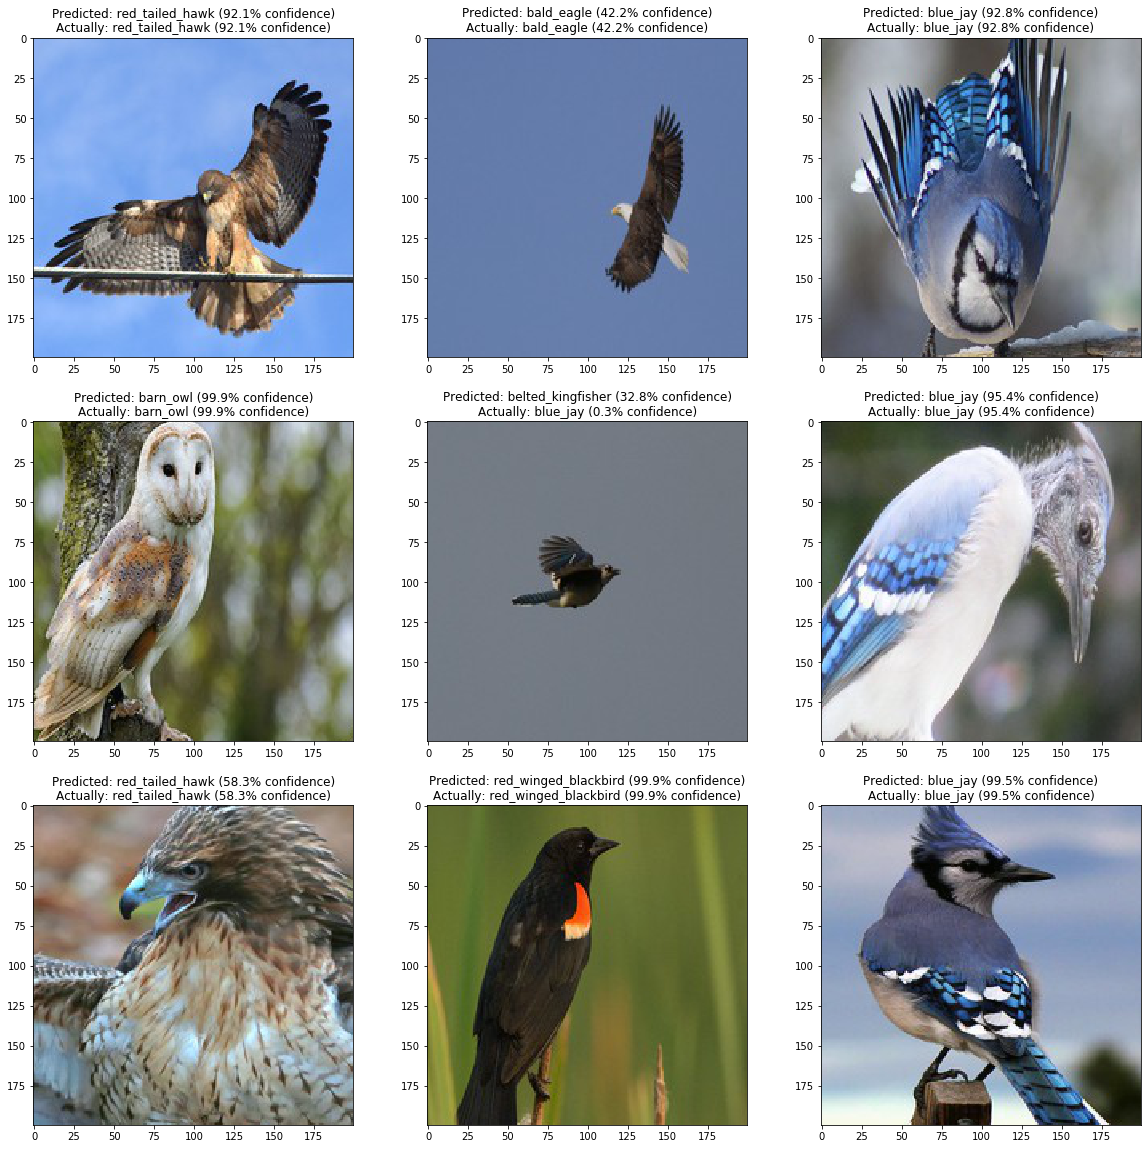

In [17]:
def display_k_mismatches(k, mismatches):
    fig, axs = plt.subplots(3, 3)
    fig.set_size_inches(20, 20)
    for i in range(k):
        predicted = mismatches[i][0]
        actual = mismatches[i][1]
        axs[i//3, i % 3].set_title('Predicted: {} ({:.1f}% confidence)\nActually: {} ({:.1f}% confidence)'.format(
            classes[predicted],
            mismatches[i][3][predicted]*100,
            classes[mismatches[i][1]],
            mismatches[i][3][actual]*100
            ))
        axs[i//3, i % 3].imshow(unnormalize(mismatches[i][2].transpose(1, 2, 0), mean, std))
    fig.savefig('figs/4mismatches.png')
    fig.show()
display_k_mismatches(k, mismatches)